# 01. NFL Data Preparation & League-Wide EDA

**Goal:**  
Prepare 2019–2024 NFL play-by-play (PBP) data, compute team-level EPA metrics, and perform initial league-wide exploratory analysis.

**Contents:**  
- Load PBP data (2019–2024)  
- Clean and filter meaningful offensive/defensive plays  
- Aggregate EPA metrics at team–game and team–season level  
- Generate league-wide summary statistics and visualizations  

**Output Files Saved:**  
- `data/processed/team_game_epa_2019_2024.csv`  
- `data/processed/team_season_epa_2019_2024.csv`  

These files are used in Notebook 02 and 03.

## 1. Install nfl_data

In [4]:
pip install nfl_data_py

Note: you may need to restart the kernel to use updated packages.


## 2. Imports + Fixed Project Paths (ABSOLUTE PATH)

In [5]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set(style="whitegrid")
except ImportError:
    sns = None

import nfl_data_py as nfl

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# ---------------------------------------------------
# 🔥 절대경로로 프로젝트 루트를 고정
# ---------------------------------------------------
BASE_DIR = Path("/Users/minseobeom/Desktop/nfl-epa-analysis")

DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR      :", BASE_DIR)
print("RAW_DIR       :", RAW_DIR)
print("PROCESSED_DIR :", PROCESSED_DIR)

BASE_DIR      : /Users/minseobeom/Desktop/nfl-epa-analysis
RAW_DIR       : /Users/minseobeom/Desktop/nfl-epa-analysis/data/raw
PROCESSED_DIR : /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed


## 3. Load or Cache PBP (2019–2024)

In [9]:
# STEP 3: Load or download PBP data using import_pbp_data (2019–2024)

PBP_FILE = RAW_DIR / "pbp_2019_2024.parquet"
SEASONS = list(range(2019, 2025))  # 2019~2024

if PBP_FILE.exists():
    print(f"[INFO] Loading cached PBP data from {PBP_FILE}")
    pbp_df = pd.read_parquet(PBP_FILE)
else:
    print(f"[INFO] Cached file not found. Downloading PBP data for seasons: {SEASONS}")
    # 🔥 여기서 load_pbp_data가 아니라 import_pbp_data 사용
    pbp_df = nfl.import_pbp_data(SEASONS)
    print(f"[INFO] Loaded PBP shape: {pbp_df.shape}")
    pbp_df.to_parquet(PBP_FILE)
    print(f"[INFO] Saved raw PBP to {PBP_FILE}")

pbp_df.shape

[INFO] Cached file not found. Downloading PBP data for seasons: [2019, 2020, 2021, 2022, 2023, 2024]
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
[INFO] Loaded PBP shape: (293478, 397)
[INFO] Saved raw PBP to /Users/minseobeom/Desktop/nfl-epa-analysis/data/raw/pbp_2019_2024.parquet


(293478, 397)

## 4. Schema Inspection (Columns, Head)

In [10]:
print("Rows, Columns:", pbp_df.shape)

print("\nSample columns:")
sample_cols = [
    "season", "week", "game_id", "play_id",
    "posteam", "defteam", "home_team", "away_team",
    "play_type", "epa"
]

existing_cols = [c for c in sample_cols if c in pbp_df.columns]
display(pbp_df[existing_cols].head())

print("\nAll columns (first 50):")
list(pbp_df.columns)[:50]

Rows, Columns: (293478, 397)

Sample columns:


,season,week,game_id,play_id,posteam,defteam,home_team,away_team,play_type,epa
0,2019,1,2019_01_ATL_MIN,1.0,None,None,MIN,ATL,None,-0.000000
1,2019,1,2019_01_ATL_MIN,36.0,ATL,MIN,MIN,ATL,kickoff,-0.000000
2,2019,1,2019_01_ATL_MIN,51.0,ATL,MIN,MIN,ATL,pass,-1.658763
3,2019,1,2019_01_ATL_MIN,79.0,ATL,MIN,MIN,ATL,run,-0.538914
4,2019,1,2019_01_ATL_MIN,100.0,ATL,MIN,MIN,ATL,run,0.142138



All columns (first 50):


['play_id',
 'game_id',
 'old_game_id_x',
 'home_team',
 'away_team',
 'season_type',
 'week',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team']

## 5. Keep Only EPA-valid Plays

In [18]:
# STEP 5: Keep only rows with valid EPA AND valid teams

pbp_epa = pbp_df[
    pbp_df["epa"].notna()
    & pbp_df["posteam"].notna()
    & pbp_df["defteam"].notna()
].copy()

print("Original shape :", pbp_df.shape)
print("EPA-valid + team-valid shape:", pbp_epa.shape)
print("Seasons in filtered data:", sorted(pbp_epa["season"].unique()))
print("Sample after filtering:")
display(
    pbp_epa[
        ["season", "week", "game_id", "play_id",
         "posteam", "defteam", "home_team", "away_team",
         "play_type", "epa"]
    ].head()
)

Original shape : (293478, 397)
EPA-valid + team-valid shape: (276011, 397)
Seasons in filtered data: [2019, 2020, 2021, 2022, 2023, 2024]
Sample after filtering:


,season,week,game_id,play_id,posteam,defteam,home_team,away_team,play_type,epa
1,2019,1,2019_01_ATL_MIN,36.0,ATL,MIN,MIN,ATL,kickoff,-0.000000
2,2019,1,2019_01_ATL_MIN,51.0,ATL,MIN,MIN,ATL,pass,-1.658763
3,2019,1,2019_01_ATL_MIN,79.0,ATL,MIN,MIN,ATL,run,-0.538914
4,2019,1,2019_01_ATL_MIN,100.0,ATL,MIN,MIN,ATL,run,0.142138
5,2019,1,2019_01_ATL_MIN,121.0,ATL,MIN,MIN,ATL,punt,-4.034299


## 6. Offensive EPA Aggregation

In [19]:
offense_group = (
    pbp_epa
    .groupby(["season", "posteam"], dropna=True)
    .agg(
        off_plays=("play_id", "count"),
        off_epa_sum=("epa", "sum"),
        off_epa_mean=("epa", "mean"),
    )
    .reset_index()
    .rename(columns={"posteam": "team"})
)

print("Offense table shape:", offense_group.shape)
offense_group.head()

Offense table shape: (192, 5)


,season,team,off_plays,off_epa_sum,off_epa_mean
0,2019,ARI,1321,-29.075460,-0.022010
1,2019,ATL,1434,-12.499887,-0.008717
2,2019,BAL,1471,187.738037,0.127626
3,2019,BUF,1437,-57.080254,-0.039722
4,2019,CAR,1402,-118.092926,-0.084232


## 7. Defensive EPA Aggregation

In [20]:
defense_group = (
    pbp_epa
    .groupby(["season", "defteam"], dropna=True)
    .agg(
        def_plays=("play_id", "count"),
        def_epa_mean=("epa", "mean"),
    )
    .reset_index()
    .rename(columns={"defteam": "team"})
)

print("Defense table shape:", defense_group.shape)
defense_group.head()

Defense table shape: (192, 4)


,season,team,def_plays,def_epa_mean
0,2019,ARI,1418,0.044271
1,2019,ATL,1309,0.004228
2,2019,BAL,1316,-0.059588
3,2019,BUF,1383,-0.092847
4,2019,CAR,1378,0.033184


## 8. Merge Offense + Defense (Team-Season EPA Table)

In [21]:
team_season_epa = (
    offense_group
    .merge(defense_group, on=["season", "team"], how="inner")
    .sort_values(["season", "team"])
    .reset_index(drop=True)
)

print("Merged table shape:", team_season_epa.shape)
team_season_epa.head()

Merged table shape: (192, 7)


,season,team,off_plays,off_epa_sum,off_epa_mean,def_plays,def_epa_mean
0,2019,ARI,1321,-29.075460,-0.022010,1418,0.044271
1,2019,ATL,1434,-12.499887,-0.008717,1309,0.004228
2,2019,BAL,1471,187.738037,0.127626,1316,-0.059588
3,2019,BUF,1437,-57.080254,-0.039722,1383,-0.092847
4,2019,CAR,1402,-118.092926,-0.084232,1378,0.033184


## 9. Save Processed Output

In [16]:
OUT_PARQUET = PROCESSED_DIR / "team_season_epa_2019_2024.parquet"
OUT_CSV = PROCESSED_DIR / "team_season_epa_2019_2024.csv"

team_season_epa.to_parquet(OUT_PARQUET, index=False)
team_season_epa.to_csv(OUT_CSV, index=False)

print(f"Saved:\n- {OUT_PARQUET}\n- {OUT_CSV}")

Saved:
- /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed/team_season_epa_2019_2024.parquet
- /Users/minseobeom/Desktop/nfl-epa-analysis/data/processed/team_season_epa_2019_2024.csv


## 10. First Visualization

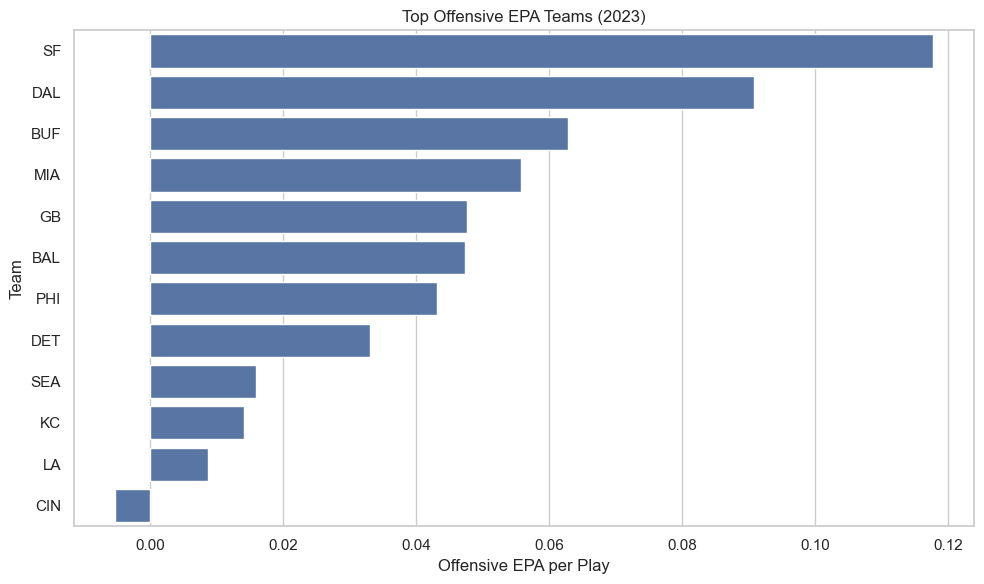

In [17]:
target_season = 2023

plot_df = (
    team_season_epa
    .query("season == @target_season")
    .sort_values("off_epa_mean", ascending=False)
    .head(12)
)

plt.figure(figsize=(10, 6))

if sns:
    sns.barplot(data=plot_df, x="off_epa_mean", y="team")
else:
    plt.barh(plot_df["team"], plot_df["off_epa_mean"])
    plt.gca().invert_yaxis()

plt.xlabel("Offensive EPA per Play")
plt.ylabel("Team")
plt.title(f"Top Offensive EPA Teams ({target_season})")
plt.tight_layout()
plt.show()